# THREE HIDDEN LAYER NEURAL NETWORK FOR MULTI-CLASS CLASSIFICATION

## Import Modules

In [186]:
import os
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline

In [190]:
TOTAL_DATASET_SIZE = 2000
CLASSES_NO = 5

## Dataset Generation

In [107]:
def load_dataset(N):
    X = []
    Y = []
    
    lim = [-500, -100, 0, 100, 500]
    
    Qs = [
        [np.random.randint(lim[0], lim[2], size=N), np.random.randint(lim[3], lim[4], size=N)], #1
        [np.random.randint(lim[2], lim[4], size=N), np.random.randint(lim[3], lim[4], size=N)], #2
        [np.random.randint(lim[0], lim[2], size=N), np.random.randint(lim[0], lim[1], size=N)], #3
        [np.random.randint(lim[2], lim[4], size=N), np.random.randint(lim[0], lim[1], size=N)], #4
        [np.random.randint(lim[0], lim[4], size=N), np.random.randint(lim[1], lim[3], size=N)]  #5
    ]
    
    for i, Q in enumerate(Qs):
        p = [[x,y] for x,y in zip(*Q)]
        Y += [i] * len(p)
        X += p

    X, Y = np.array(X), np.array(Y)
    indcs = np.array(list(range(len(Y))))
    np.random.shuffle(indcs)
    
    return (X[indcs], Y[indcs])

In [116]:
def plot_dataset(X, Y):
    plt.figure()
    class_colors = ['m', 'r', 'g', 'b', 'y']
    class_markers = ['4', '.', '^', '*', 'x']
    for c in range(5):
        plt.scatter(X[Y == c,0], X[Y == c,1], s=15, color=class_colors[c], marker=class_markers[c], label=f'class {c}')

    plt.title('XY-plane dataset')
    plt.xlabel('X coord')
    plt.ylabel('Y coord')
    plt.legend()
    plt.show()

In [191]:
X, Y = load_dataset(TOTAL_DATASET_SIZE//CLASSES_NO)
print(X.shape, Y.shape, X.T.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=None)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2000, 2) (2000,) (2, 2000)
(1200, 2) (800, 2) (1200,) (800,)


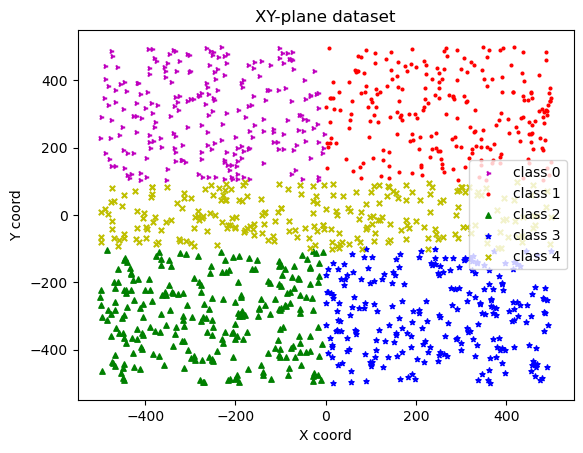

In [192]:
plot_dataset(X_train, Y_train)

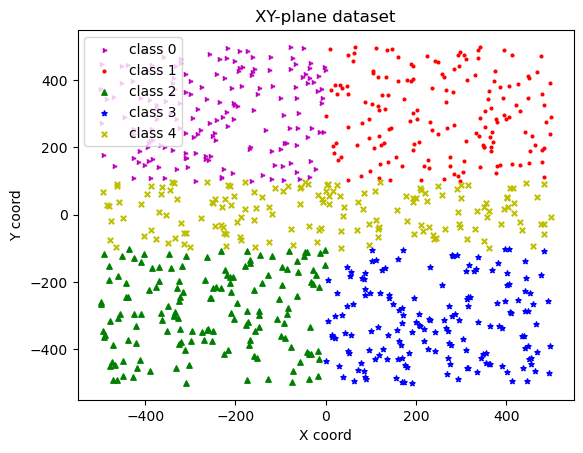

In [193]:
plot_dataset(X_test, Y_test)

## 3 Hidden Layer Neural Network

In [145]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayer = 2
        neuronsOfHiddenLayer1 = 10
        neuronsOfHiddenLayer2 = 10
        neuronsOfHiddenLayer3 = 10
        outputLayer = 5
        
        self.learning_rate = 0.02
        
        self.W_1HI  = np.random.randn(inputLayer, neuronsOfHiddenLayer1)
        self.B_H1 = np.random.randn(1, neuronsOfHiddenLayer1)

        self.W_2H1H = np.random.randn(neuronsOfHiddenLayer1, neuronsOfHiddenLayer2)
        self.B_H2 = np.random.randn(1, neuronsOfHiddenLayer2)
        
        self.W_3H2H = np.random.randn(neuronsOfHiddenLayer2, neuronsOfHiddenLayer3)
        self.B_H3 = np.random.randn(1, neuronsOfHiddenLayer3)
        
        self.W_O3H  = np.random.randn(neuronsOfHiddenLayer3, outputLayer)
        self.B_O  = np.random.randn(1, outputLayer)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1-x)
        else:
            return 1 / (1 + np.exp(-x))
        
    def feedForward(self, X):
        inputOfHiddenLayer1 = np.dot(X, self.W_1HI) + self.B_H1
        self.outputOfHiddenLayer1 = self.sigmoid(inputOfHiddenLayer1)
        
        inputOfHiddenLayer2 = np.dot(self.outputOfHiddenLayer1, self.W_2H1H) + self.B_H2
        self.outputOfHiddenLayer2 = self.sigmoid(inputOfHiddenLayer2)
        
        inputOfHiddenLayer3 = np.dot(self.outputOfHiddenLayer2, self.W_3H2H) + self.B_H3
        self.outputOfHiddenLayer3 = self.sigmoid(inputOfHiddenLayer3)
        
        inputOfOutput = np.dot(self.outputOfHiddenLayer3, self.W_O3H) + self.B_O
        pred = self.softmax(inputOfOutput)
        return pred

    def backPropagation(self, X, Y, pred):
        if Y.ndim == 1:
            Y_one_hot = np.zeros((Y.size, self.W_O3H.shape[1]))
            Y_one_hot[np.arange(Y.size), Y] = 1
        else:
            Y_one_hot = Y
            
        errorOfOutput = Y_one_hot - pred
        deltaOfOutput = self.learning_rate * errorOfOutput
        
        errorOfHiddenLayer3 = deltaOfOutput.dot(self.W_O3H.T)
        deltaOfHiddenLayer3 = self.learning_rate * errorOfHiddenLayer3 * self.sigmoid(self.outputOfHiddenLayer3, der=True)
        
        errorOfHiddenLayer2 = deltaOfHiddenLayer3.dot(self.W_3H2H.T)
        deltaOfHiddenLayer2 = self.learning_rate * errorOfHiddenLayer2 * self.sigmoid(self.outputOfHiddenLayer2, der=True)
        
        errorOfHiddenLayer1 = deltaOfHiddenLayer2.dot(self.W_2H1H.T)
        deltaOfHiddenLayer1 = self.learning_rate * errorOfHiddenLayer1 * self.sigmoid(self.outputOfHiddenLayer1, der=True)
        
        self.W_1HI  += X.T.dot(deltaOfHiddenLayer1)
        self.W_2H1H += self.outputOfHiddenLayer1.T.dot(deltaOfHiddenLayer2)
        self.W_3H2H += self.outputOfHiddenLayer2.T.dot(deltaOfHiddenLayer3)
        self.W_O3H  += self.outputOfHiddenLayer3.T.dot(deltaOfOutput)

        self.B_H1 += np.sum(deltaOfHiddenLayer1, axis=0, keepdims=True)
        self.B_H2 += np.sum(deltaOfHiddenLayer2, axis=0, keepdims=True)
        self.B_H3 += np.sum(deltaOfHiddenLayer3, axis=0, keepdims=True)
        self.B_O += np.sum(deltaOfOutput, axis=0, keepdims=True)
    
    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)


/tmp/ipykernel_29027/502458034.py:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


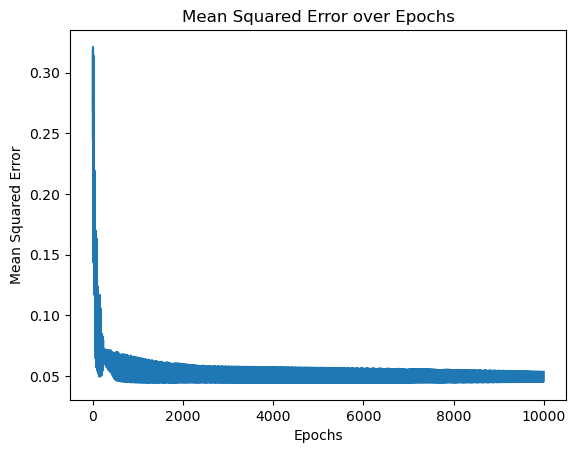

In [194]:
# Accomodating for multi-class classification
Y_train_one_hot = np.zeros((Y_train.size, CLASSES_NO))
Y_train_one_hot[np.arange(Y_train.size), Y_train] = 1

NN = NeuralNetwork()
err = []

for i in range(10000):
    NN.train(X_train, Y_train_one_hot)
    output = NN.feedForward(X_train)
    err.append(np.mean(np.square(Y_train_one_hot - output)))

plt.figure()
plt.plot(err)
plt.title("Mean Squared Error over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

## Performance

In [201]:
# Evaluating the model on the test set
Y_test_one_hot = np.zeros((Y_test.size, CLASSES_NO))
Y_test_one_hot[np.arange(Y_test.size), Y_test] = 1

# Prediction from model
predictions = NN.feedForward(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculating the evaluation metrics
accuracy = accuracy_score(Y_test, predicted_classes) * 100  # Convert to percentage
precision = precision_score(Y_test, predicted_classes, average=None, zero_division=0) * 100  # per class
recall = recall_score(Y_test, predicted_classes, average=None, zero_division=0) * 100  # per class
f1 = f1_score(Y_test, predicted_classes, average=None, zero_division=0) * 100  # per class

print(f"Accuracy: {accuracy:.2f}%")
print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

print(f"Overall Precision: {precision.mean():.2f}%")
print(f"Overall Recall: {recall.mean():.2f}%")
print(f"Overall F1 Score: {f1.mean():.2f}%")

Accuracy: 80.25%
Precision (per class): [77.31481481 80.1980198  83.51648352 80.5         0.        ]
Recall (per class): [100. 100. 100. 100.   0.]
F1 Score (per class): [87.20626632 89.01098901 91.01796407 89.1966759   0.        ]
Overall Precision: 64.31%
Overall Recall: 80.00%
Overall F1 Score: 71.29%


/tmp/ipykernel_29027/502458034.py:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


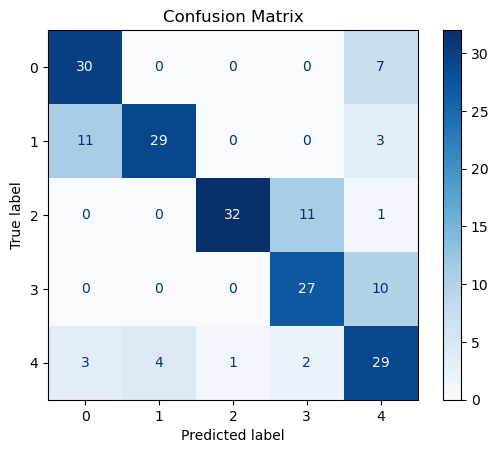

In [187]:
# Confusion Matrix
cm = confusion_matrix(Y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(CLASSES_NO))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

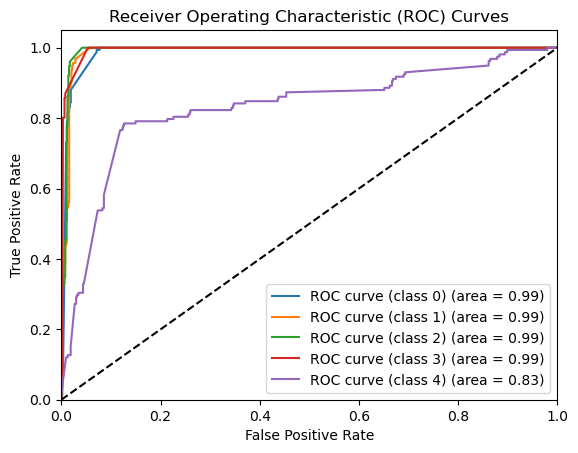

In [197]:
# ROC Curves
Y_test_binarized = label_binarize(Y_test, classes=np.arange(CLASSES_NO))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(CLASSES_NO):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(CLASSES_NO):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

## Conclusion



  Modifications: 

    - Dataset generation
    - softmax activation function
    - One hot encoding
    - 3 hidden layer with 10 neurons
    - Added bias
    - train and test split
    - Used relevent evaulation metrics
    - Used ROC and Confusion Matrix visualizers 